In [2]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
!ls

codes	       violence_detection_model.pth
tf-gpu-env     violence_detection_model_state_dict.pth
torch-gpu-env


In [4]:
!ls /mnt/c/Users/User/Documents/DATASETS/VIOLENCIA/archive/Real\ Life\ Violence\ Dataset

NonViolence  Violence


# Parameters

In [5]:
img_height, img_width = 224, 224
batch_size = 16
epochs = 10
learning_rate = 0.001
sequence_length = 10  # Number of frames to consider in each sequence
dataset_path = '/mnt/c/Users/User/Documents/DATASETS/VIOLENCIA/archive/Real Life Violence Dataset'

# Device configuration

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
print(device)

cuda


# transformations

In [8]:
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# extract frames from a video

In [9]:
def extract_frames(video_path, sequence_length, interval=10):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0
    while len(frames) < sequence_length:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % interval == 0:
            frame = cv2.resize(frame, (img_height, img_width))
            frames.append(frame)
        frame_count += 1
    cap.release()

    # Handle cases where there are fewer frames than sequence_length
    if len(frames) < sequence_length:
        while len(frames) < sequence_length:
            frames.append(frames[-1] if frames else cv2.resize(np.zeros((img_height, img_width, 3), dtype=np.uint8), (img_height, img_width)))
    else:
        frames = frames[:sequence_length]

    return frames

# Dataset

In [10]:
class VideoDataset(Dataset):
    def __init__(self, video_files, labels, transform=None, sequence_length=10):
        self.video_files = video_files
        self.labels = labels
        self.transform = transform
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        frames = extract_frames(self.video_files[idx], self.sequence_length)
        if self.transform:
            frames = [self.transform(frame) for frame in frames]
        label = self.labels[idx]
        return torch.stack(frames), label

# Load dataset

In [11]:
def load_dataset(dataset_path):
    video_files = []
    labels = []
    classes = os.listdir(dataset_path)
    for label, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        videos = os.listdir(class_path)
        for video_name in videos:
            video_path = os.path.join(class_path, video_name)
            video_files.append(video_path)
            labels.append(label)
    return video_files, labels

# Split

In [12]:
video_files, labels = load_dataset(dataset_path)
train_videos, temp_videos, train_labels, temp_labels = train_test_split(video_files, labels, test_size=0.3, random_state=42)
val_videos, test_videos, val_labels, test_labels = train_test_split(temp_videos, temp_labels, test_size=0.5, random_state=42)

In [13]:
train_dataset = VideoDataset(train_videos, train_labels, transform=data_transforms, sequence_length=sequence_length)
val_dataset = VideoDataset(val_videos, val_labels, transform=data_transforms, sequence_length=sequence_length)
test_dataset = VideoDataset(test_videos, test_labels, transform=data_transforms, sequence_length=sequence_length)

# DataLoader

In [14]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Model

In [15]:
class MobileNetGRU(nn.Module):
    def __init__(self, hidden_dim, num_classes, num_layers=1):
        super(MobileNetGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Load pre-trained MobileNetV2
        self.mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        self.mobilenet.classifier = nn.Identity()  # Remove the last fully connected layer

        # GRU
        self.gru = nn.GRU(input_size=1280, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.size()

        # Reshape to (batch_size * seq_length, c, h, w) to feed each frame into MobileNet
        x = x.view(batch_size * seq_length, c, h, w)
        with torch.no_grad():
            x = self.mobilenet(x)
        
        # Reshape back to (batch_size, seq_length, 1280) to feed into GRU
        x = x.view(batch_size, seq_length, -1)

        # GRU
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        x, _ = self.gru(x, h0)

        # Classification
        x = self.fc(x[:, -1, :])  # Use the output of the last GRU cell

        return x

In [16]:
hidden_dim = 512
num_classes = 2
model = MobileNetGRU(hidden_dim, num_classes).to(device)

# loss function and optimizer

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training 

In [22]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
        val_loss_history.append(val_epoch_loss)
        val_acc_history.append(val_epoch_acc.item())

        print(f'Epoch {epoch}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [23]:
model, train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, criterion, optimizer, train_loader, val_loader, epochs)

[h264 @ 0xcfa1600] mb_type 104 in P slice too large at 98 31
[h264 @ 0xcfa1600] error while decoding MB 98 31


Epoch 0/10, Loss: 0.3869, Acc: 0.8250, Val Loss: 0.1942, Val Acc: 0.9300


[h264 @ 0x246eb8c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x246eb8c0] error while decoding MB 98 31


Epoch 1/10, Loss: 0.1903, Acc: 0.9293, Val Loss: 0.1454, Val Acc: 0.9400


[h264 @ 0x248b3b80] mb_type 104 in P slice too large at 98 31
[h264 @ 0x248b3b80] error while decoding MB 98 31


Epoch 2/10, Loss: 0.1322, Acc: 0.9521, Val Loss: 0.1619, Val Acc: 0.9200


[h264 @ 0x24fee100] mb_type 104 in P slice too large at 98 31
[h264 @ 0x24fee100] error while decoding MB 98 31


Epoch 3/10, Loss: 0.1111, Acc: 0.9543, Val Loss: 0.3475, Val Acc: 0.8333


[h264 @ 0x24812c40] mb_type 104 in P slice too large at 98 31
[h264 @ 0x24812c40] error while decoding MB 98 31


Epoch 4/10, Loss: 0.1371, Acc: 0.9493, Val Loss: 0.2999, Val Acc: 0.8667


[h264 @ 0x2477a040] mb_type 104 in P slice too large at 98 31
[h264 @ 0x2477a040] error while decoding MB 98 31


Epoch 5/10, Loss: 0.1746, Acc: 0.9186, Val Loss: 0.1003, Val Acc: 0.9633


[h264 @ 0x24794000] mb_type 104 in P slice too large at 98 31
[h264 @ 0x24794000] error while decoding MB 98 31


Epoch 6/10, Loss: 0.0636, Acc: 0.9757, Val Loss: 0.2390, Val Acc: 0.9167


[h264 @ 0x24af94c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x24af94c0] error while decoding MB 98 31


Epoch 7/10, Loss: 0.0670, Acc: 0.9686, Val Loss: 0.2632, Val Acc: 0.8933


[h264 @ 0x24af8b80] mb_type 104 in P slice too large at 98 31
[h264 @ 0x24af8b80] error while decoding MB 98 31


Epoch 8/10, Loss: 0.0526, Acc: 0.9800, Val Loss: 0.0874, Val Acc: 0.9667


[h264 @ 0x252bc9c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x252bc9c0] error while decoding MB 98 31


Epoch 9/10, Loss: 0.0576, Acc: 0.9786, Val Loss: 0.1182, Val Acc: 0.9533


# Evaluate 

In [24]:
model.eval()
test_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

test_acc = test_corrects.double() / len(test_loader.dataset)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9400


# Plotting

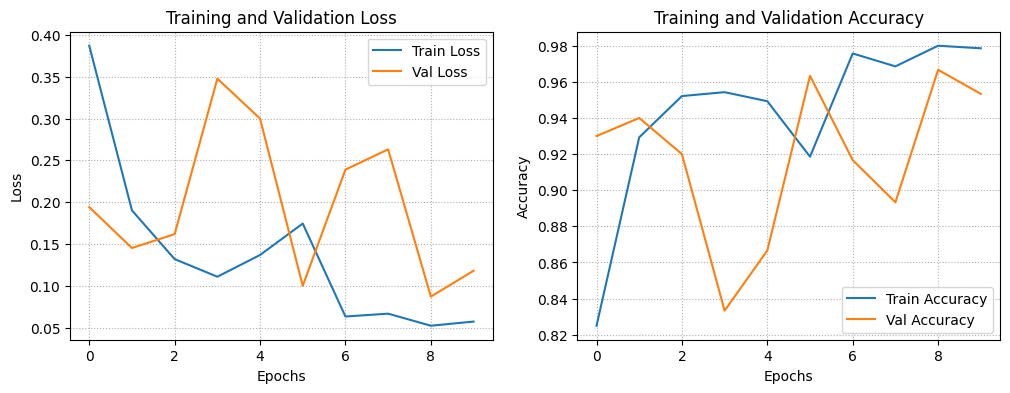

In [25]:
epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, label='Train Loss')
plt.plot(epochs_range, val_loss_history, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(ls=":")
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_history, label='Train Accuracy')
plt.plot(epochs_range, val_acc_history, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(ls=":")
plt.title('Training and Validation Accuracy')

plt.show()

In [20]:
os.chdir("/mnt/c/Users/User/Documents/codes/DL/deeplearning_codes/")

In [21]:
!ls

MNIST_Ejm_GPU.ipynb	  output_video.mp4
README.md		  test_camera.ipynb
V_1.mp4			  test_show_video.py
convert_model_to_h.ipynb  tf_gpu_test1.ipynb
images			  tutorial1_torch.ipynb
modelo.h		  violence-detection-classifier.ipynb
modelo.tflite		  violence_detection_model.pth
output_video.gif	  violence_detection_model_state_dict.pth


In [22]:
# Save the entire model
torch.save(model, 'violence_detection_model.pth')

# Or save just the model state dict (recommended)
torch.save(model.state_dict(), 'violence_detection_model_state_dict.pth')

In [31]:
!ls

MNIST_Ejm_GPU.ipynb	  tf_gpu_test1.ipynb
README.md		  tutorial1_torch.ipynb
convert_model_to_h.ipynb  violence-detection-classifier.ipynb
images			  violence_detection_model.pth
modelo.h		  violence_detection_model_state_dict.pth
modelo.tflite


In [31]:
import cv2
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Load your PyTorch model
model = torch.load('violence_detection_model.pth')
model.eval()

# Define transforms - adjust according to your model's training
#transform = transforms.Compose([
#    transforms.Resize((64, 64)),
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
#                        std=[0.229, 0.224, 0.225])
#])


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Initialize webcam
cap = cv2.VideoCapture("/mnt/c/Users/User/Documents/DATASETS/VIOLENCIA/archive/Real Life Violence Dataset/Violence/V_1.mp4")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break
    
    # Convert frame to PIL Image
    #pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    pil_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Preprocess frame
    input_tensor = transform(pil_image)
    
    
    # Get prediction
    with torch.no_grad():
        #input_batch = input_tensor.unsqueeze(0).to(device)
        input_batch = input_tensor.to(device)
        output = model(input_batch)
        prediction = torch.sigmoid(output)
        prob = prediction.item()
    
    # Display result
    label = "Violence" if prob > 0.5 else "No Violence"
    color = (0, 0, 255) if label == "Violence" else (0, 255, 0)
    
    #cv2.putText(frame, f"{label}: {prob:.2f}", 
    #            (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    
    #cv2.imshow('Violence Detection', frame)
    
    #if cv2.waitKey(1) & 0xFF == ord('q'):
    #    break

cap.release()
cv2.destroyAllWindows()

/tmp/ipykernel_216838/76353674.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('violence_detection_model.pth')


ValueError: not enough values to unpack (expected 5, got 3)

In [33]:
#import cv2
#import torch
#import torchvision.transforms as transforms
#import numpy as np
from collections import deque

# Definir el tamaño de la imagen y la longitud de la secuencia
img_height, img_width = 64, 64  # Ajusta estos valores según lo que espera tu modelo
seq_length = 16  # Número de frames por secuencia

# Cargar el modelo de PyTorch
model = torch.load('violence_detection_model.pth')
model.eval()

# Definir las transformaciones
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Inicializar el video
cap = cv2.VideoCapture("/mnt/c/Users/User/Documents/DATASETS/VIOLENCIA/archive/Real Life Violence Dataset/Violence/V_1.mp4")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Buffer para acumular frames y crear la secuencia
frame_buffer = deque(maxlen=seq_length)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break
    
    # Convertir el frame a RGB para Pillow
    pil_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Preprocesar el frame
    input_tensor = transform(pil_image)
    frame_buffer.append(input_tensor)

    # Procesar cuando el buffer tenga suficientes frames
    if len(frame_buffer) == seq_length:
        # Crear el tensor de entrada con la dimensión de secuencia temporal
        input_batch = torch.stack(list(frame_buffer)).unsqueeze(0).to(device)  # (1, seq_length, C, H, W)

        # Obtener predicción
        with torch.no_grad():
            output = model(input_batch)
            prediction = torch.sigmoid(output)
            prob = prediction.item()
        
        # Mostrar el resultado
        label = "Violence" if prob > 0.5 else "No Violence"
        color = (0, 0, 255) if label == "Violence" else (0, 255, 0)
        
        cv2.putText(frame, f"{label}: {prob:.2f}", 
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    
    cv2.imshow('Violence Detection', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


/tmp/ipykernel_216838/1513801143.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('violence_detection_model.pth')


: 

: 

: 